# Bias correction with gradient-boosted trees

**Authors**: [Matthew Chantry](https://www.ecmwf.int/en/about/who-we-are/staff-profiles/matthew-chantry), [Jesper Dramsch](https://www.ecmwf.int/en/about/who-we-are/staff-profiles/jesper-dramsch) and [Fenwick Cooper](https://www.physics.ox.ac.uk/our-people/cooperf)

*This notebook was last tested and operational on 02/10/2025. Please [report any issues](https://github.com/ecmwf-training/ml-examples/issues).*

:::{admonition} Running this notebook
:class: tip, dropdown
This notebook can be run/accessed on the following free online platforms. Please note they are not officially supported by or linked with ECMWF. See [Running the notebooks](sec:running_notebooks) for more details.

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/ml-examples/blob/develop/ex_XGBoost_Postprocessing.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/ml-examples/blob/develop/ex_XGBoost_Postprocessing.ipynb)
[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/ml-examples/develop?labpath=ex_XGBoost_Postprocessing.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/ml-examples/blob/develop/ex_XGBoost_Postprocessing.ipynb)
:::

## Introduction

In this example we will apply a gradient-boosted tree model (XGBoost) to the ECMWF forecast of surface temperature. Specifically, we are trying to predict the difference between station observations of 2m-temperature and the corresponding forecast prediction at the nearest gridpoint to the observation location. If we can accurately predict this difference (the forecast error) we can compensate for it, making the forecast more accurate. This type of approach is called *bias correction*, which is a form of statistical post-processing.

### About surface observation processing

Surface observation processing refers to the process of collecting and analyzing weather observations taken at the Earth's surface by weather stations and other observing platforms. This typically includes measuring temperature, humidity, wind speed and direction, precipitation, and other meteorological variables. The observations are then used to produce weather forecasts and warnings, as well as to analyze and understand weather patterns. The process typically involves quality control checks to ensure the observations are accurate and reliable, as well as the use of automated systems to process and disseminate the observations in near real-time.

Machine learning can be applied in surface observation processing in several ways. One way is to use machine learning algorithms to help improve the accuracy of forecasts by analyzing large amounts of historical weather data. The algorithms can make more accurate predictions about future weather by learning from past weather patterns. Another way machine learning can be applied is in the quality control of the observations. Machine learning models can be trained to identify and flag any observations that may be incorrect or unreliable. This quality control can help ensure that only the most accurate and reliable weather information is used for forecasts and other purposes.

In addition, machine learning can be used to automate the process of surface observation processing, allowing the system to run more efficiently and quickly. This can help produce forecasts and warnings more quickly and with higher accuracy, providing more detailed and accurate information to the public.

Overall, the use of Machine learning in surface observation processing can help improve the accuracy and speed of weather forecasting, and provide more detailed and accurate information to the public.

### Gradient boosting

In this notebook we will use [XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/model.html), a popular machine learning algorithm for supervised learning (regression and classification).

XGBoost implements a tree-based gradient boosting algorithm consisting of an ensemble of decision trees. Each decision tree divides the feature space into partitions and assigns a constant value, resulting in a blocky and very approximate fit - these trees are referred to as "weak learners". However, gradient boosting works hierarchically, such that each tree is fitted to the residuals of the ensemble of trees that came before it. By stacking many of these trees on top of each other, the result is an ensemble model that can efficiently tackle complex regression and classification problems.

Among the advantages of XGBoost are that it has been proven to work very well in many applications, it handles overfitting relatively well, and has built in feature importance measures via [Shapely values](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).

## Prepare your environment

The following packages are used to process and model the data:

- numpy for handling arrays and mathematical functions
- xgboost for building boosted tree regression models
- scikit-learn for machine learning tools ([imported as sklearn](https://pythonorp.com/scikit-learn-vs-sklearn-heres-the-actual-difference/))
- matplotlib for plots
- shap for estimating feature importance (see end of notebook)

In [8]:
import numpy as np
import xgboost as xgb

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import shap

Before going further, we also have to download a utility function for plotting. This is contained within a [plugin](https://github.com/mchantry/climetlab-mltc-surface-observation-postprocessing) to the [Climetlab](https://climetlab.readthedocs.io/en/latest/) package, which is no longer updated. In order to avoid a dependency on this package (which can cause errors in some environments), we load the function directly from the GitHub source code.

In [2]:
# Download the raw Python file from GitHub
!wget -O utils.py https://raw.githubusercontent.com/mchantry/climetlab-mltc-surface-observation-postprocessing/master/climetlab_mltc_surface_observation_postprocessing/utils.py

# Run it in the notebook so functions are available
%run utils.py


--2025-10-02 07:59:15--  https://raw.githubusercontent.com/mchantry/climetlab-mltc-surface-observation-postprocessing/master/climetlab_mltc_surface_observation_postprocessing/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2451 (2.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.39K  --.-KB/s    in 0s      

2025-10-02 07:59:15 (28.9 MB/s) - ‘utils.py’ saved [2451/2451]



## Load data

We will now download the dataset: this comprises 36-hour forecast errors of 2m-temperature from a ECMWF's high resolution forecast system, using station observations as the truth. Currently there are three variables in the dataset:

- `forecast_error`: the difference between the forecasted value of 2m-temperature and the observed value, in °C.
- `time_of_day`: the local time of day, in decimal hours. Useful for diagnosing the diurnal cycle model bias.
- `soil_temperature`: the model soil temperature, in °C.

For each variable, the dataset contains over 5 million datapoints covering around 8000 weather stations around the world (not specified in the dataset).

We will load each variable separately. Notice that we reshape the explanator variables (features) to 2D arrays (albeit with a single column) for compatability with scikit-learn. This may take a minute or so depending on the speed of your connection.

In [3]:
base_url = "https://object-store.os-api.cci1.ecmwf.int/sop/"

# load in variables one at a time (.reshape() puts in correct format for later)
forecast_error = np.genfromtxt(base_url + "forecast_error.csv", delimiter=",", skip_header=1).reshape(-1, 1)
soil_temperature = np.genfromtxt(base_url + "soil_temperature.csv", delimiter=",", skip_header=1).reshape(-1, 1)
time_of_day = np.genfromtxt(base_url + "time_of_day.csv", delimiter=",", skip_header=1).reshape(-1, 1)

Note that an important step of data preprocessing has already been carried out in the curation of the dataset. Spurious data has already been removed from the dataset based upon a range of categories, e.g. stations with inconsistent measurement locations, repeated values, or even physically  invalid numbers (>100°C). If you are starting on a new project this is a key step to clean the data.

Quick check on the shape of the resulting data:

In [9]:
print(forecast_error.shape)
print(soil_temperature.shape)
print(time_of_day.shape)

(5265488, 1)
(5265488, 1)
(5265488, 1)


## Prepare data

Now we can prepare the data for our model. This involves randomly splitting the data into training and testing sets, such that 80% of the data is in the training set and 20% in the testing set.

Ideally, we would like to know the geospatial location and time of our data points, because this would allow us to design our training/test sets to ensure independence (for more info, see our [ML MOOC](https://learning.ecmwf.int/course/index.php?categoryid=1)). However, we don't have this information, so random sampling will be used. We will also not create a validation set because we are not exploring a hyperparameter space.

The splitting into training and test sets can be done one in one call to the `train_test_split()` function of scikit-learn.

In [10]:
# Split each of the predictands and predictors in a random train/test split
# we use 80% of the data for training & 20% for testing
(forecast_error_train, forecast_error_test,
 time_of_day_train, time_of_day_test,
 soil_temperature_train,  soil_temperature_test) = train_test_split(forecast_error,
                                                                    time_of_day,
                                                                    soil_temperature,
                                                                    test_size = 0.2,
                                                                    random_state = 42)

**NB**: XGBoost doesn't require that the inputs be normalized. So we can go ahead and fit the model.

## Build model

Next, we train our boosting model. We begin by performing a univariate regression of the forecast error only on the time of day. In the following code, we create the `reg_one_var` model object, specifying five rounds of boosting, and fit this model to the training data.

In [11]:
reg_one_var = xgb.XGBRegressor(n_estimators=5, eval_metric=mean_absolute_error)
reg_one_var = reg_one_var.fit(
    time_of_day_train, forecast_error_train,
    # calculate the RMSE on the eval (holdout) set
    eval_set=[(time_of_day_test, forecast_error_test)],
)
reg_one_var

[0]	validation_0-rmse:2.22707	validation_0-mean_absolute_error:1.59895
[1]	validation_0-rmse:2.21512	validation_0-mean_absolute_error:1.58900
[2]	validation_0-rmse:2.20908	validation_0-mean_absolute_error:1.58426
[3]	validation_0-rmse:2.20586	validation_0-mean_absolute_error:1.58196
[4]	validation_0-rmse:2.20404	validation_0-mean_absolute_error:1.58071


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7d46f2678a40>,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5, n_jobs=None,
             num_parallel_tree=None, ...)

We will now plot the model predictions against the true values in the test set. To do this, we generate a vector of model predictions covering all hours of the day, and overlay it on the test data set for a visual comparison. Due to the large number of data points, we call our `imgBufferFromVectors()` function which creates an image based on binning the data points.

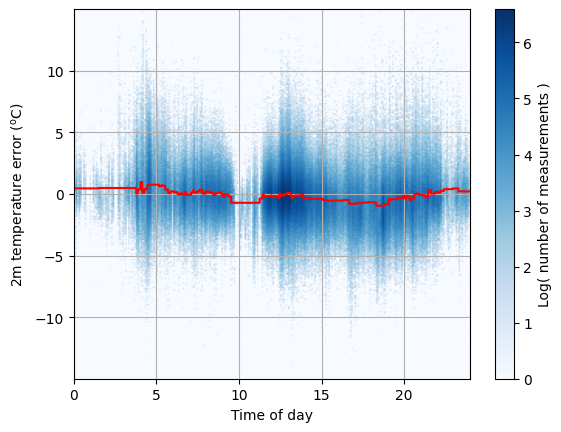

In [13]:
# Let's see how our model works across all the hours of the day
x_rep = np.arange(0,24,0.001)[...,np.newaxis]
y = reg_one_var.predict(x_rep)

# Make an image of the time of day against the forecast error
tod_buffer, ax_extent, count = imgBufferFromVectors(time_of_day_test, forecast_error_test,
                                                    nx=256, ny=256, extent=[],
                                                    calc_average=False)

# Plot the number of measurements at each time of day and forecast error
plt.imshow(np.log((count==0.0)+count),
           cmap='Blues', origin='lower',
           extent=ax_extent, aspect='auto')

plt.xlim([0, 24])
plt.grid()
plt.xlabel('Time of day')
plt.ylabel(r'2m temperature error ($^\mathrm{o}$C)')
cb = plt.colorbar()
cb.set_label('Log( number of measurements )')

# Line of best fit
plt.plot(x_rep,y,'red')

plt.show()

The model (red line) is better than nothing, but does not account for the variation in 2m temperature error at single time of day (eg. at 14:00).

We also calculate evaluation metrics based on mean absolute error (MAE) and root mean-squared error (RMSE).

In [14]:
# Calculate Root Mean Square error of predictions:

zero_test = 0.0*forecast_error_test
print('Mean Absolute Error Uncorrected:', metrics.mean_absolute_error(zero_test, forecast_error_test))
print('Root Mean Squared Error Uncorrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test)))

forecast_corrected = forecast_error_test.squeeze() - reg_one_var.predict(time_of_day_test)

print('Mean Absolute Error Corrected:', metrics.mean_absolute_error(zero_test, forecast_corrected))
print('Root Mean Squared Error Corrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_corrected)))

Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456
Mean Absolute Error Corrected: 1.580710324579216
Root Mean Squared Error Corrected: 2.2040411646290483


## Adding more predictors

Next we will add a second predictor, the model soil temperature. To understand how soil temperature is related with time of day, and the forecast error, we first create a 2D heatmap to visualise the relationship between these variables.


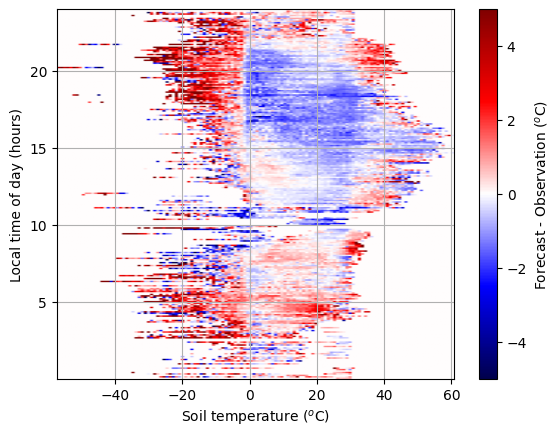

In [15]:
# Make image of the error with the new predictor
buffer, ax_extent, count = imgBufferFromVectors(soil_temperature_test,
                                                time_of_day_test,
                                                forecast_error_test,
                                                128, 256,
                                                extent = [],
                                                calc_average=True)
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

The plot shows a clear structure, such that in the evening the forecast is too warm if the soil is frozen and too cold if the soil is not. Can we learn a good representation of this error pattern?

To do this, we add the second variable to our XGBoost model. This simply involves concatenating the soil temperature array onto the time of day array, for both the training and test datasets. Then, we retrain the model. We also increase the number of boosting rounds to ten.

In [16]:
#Create the input features
X_train = np.concatenate([time_of_day_train, soil_temperature_train],axis=-1)
X_test = np.concatenate([time_of_day_test, soil_temperature_test],axis=-1)

reg_two_vars = xgb.XGBRegressor(n_estimators=10, eval_metric=mean_absolute_error)
reg_two_vars = reg_two_vars.fit(
    X_train, forecast_error_train,
    eval_set=[(X_test, forecast_error_test)],
)

[0]	validation_0-rmse:2.20656	validation_0-mean_absolute_error:1.58642
[1]	validation_0-rmse:2.18287	validation_0-mean_absolute_error:1.56942
[2]	validation_0-rmse:2.16924	validation_0-mean_absolute_error:1.55989
[3]	validation_0-rmse:2.16145	validation_0-mean_absolute_error:1.55459
[4]	validation_0-rmse:2.15621	validation_0-mean_absolute_error:1.55086
[5]	validation_0-rmse:2.15253	validation_0-mean_absolute_error:1.54818
[6]	validation_0-rmse:2.15001	validation_0-mean_absolute_error:1.54664
[7]	validation_0-rmse:2.14807	validation_0-mean_absolute_error:1.54536
[8]	validation_0-rmse:2.14676	validation_0-mean_absolute_error:1.54477
[9]	validation_0-rmse:2.14547	validation_0-mean_absolute_error:1.54385


Again, we'll check our MAE and RMSE evaluation metrics.

In [17]:
# Calculate Root Mean Square error of predictions:

zero_test = 0.0*forecast_error_test
print('Mean Absolute Error Uncorrected:', metrics.mean_absolute_error(zero_test, forecast_error_test))
print('Root Mean Squared Error Uncorrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test)))

forecast_corrected = forecast_error_test.squeeze() - reg_two_vars.predict(X_test)

print('Mean Absolute Error Corrected:', metrics.mean_absolute_error(zero_test, forecast_corrected))
print('Root Mean Squared Error Corrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_corrected)))

Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456
Mean Absolute Error Corrected: 1.5438535031158473
Root Mean Squared Error Corrected: 2.1454719313411013


By using two predictors we can impove the forecast of 2m-temperature by ~0.1 C. Let's visualise how the model corrects the forecast across the full 2D space.

In [18]:
# Run the fit model over the plot domain

# The x and y values of each point in the plot image, this covers
# the range of data observed in the data
nx = buffer.shape[0]
ny = buffer.shape[1]
x_st = np.linspace(ax_extent[0],ax_extent[1],nx)  # Represents soil_temperature
y_tod = np.linspace(ax_extent[2],ax_extent[3],ny)  # Represents time_of_day

# Create the input data
input_buffer = np.stack(np.meshgrid(y_tod,x_st),axis=-1)
X_plot = input_buffer.reshape(-1,X_train.shape[-1])

#Predict and reshape prediction back to 2D plot
raw_pred = reg_two_vars.predict(X_plot)
model_buffer = raw_pred.reshape(input_buffer.shape[:-1])

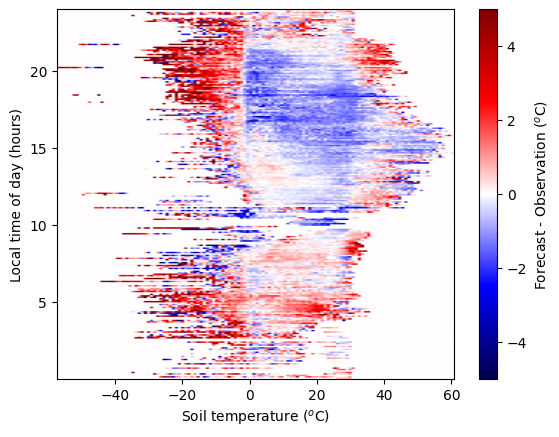

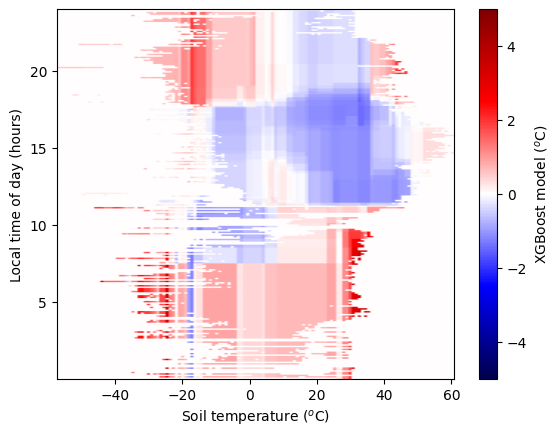

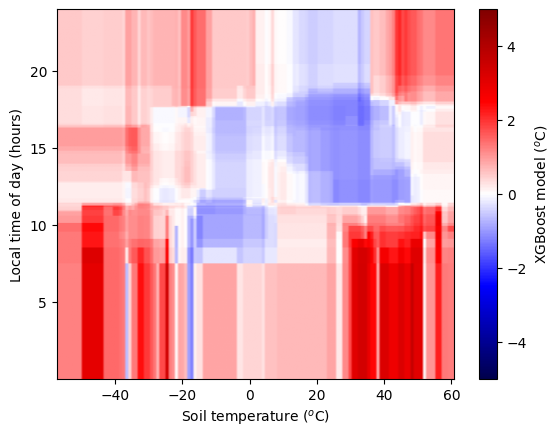

In [19]:
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

#plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

# Plot the model
plt.imshow((model_buffer)*(count>0), vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

#plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('XGBoost model ($^o$C)')

plt.show()

# Plot the model over the whole domain
plt.imshow(model_buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

#plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('XGBoost model ($^o$C)')

plt.show()

As we add more predictors and complexity to our model, it becomes better and better. But, our measurements of the forecast error are not perfect. There is some noise. We don't want our model to capture this. But an overly-complex model will. We need a simpler model, or more data. Fitting a model that is too complex for the data is called "overfitting". Here we have a large number of observations and still a relatively small number of free parameters, so overfitting is unlikely. We see that during training our errors on the training & testing dataset are comparable.

Away from where data has been provided the model does not have constraints. We should not trust this part of the feature space.

We also see different model corrections for hour 23 and hour 0, when these should be closely correlated.


## Extensions:

1. Can you beat these predictions by changing the [XGBRegressor parameters](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn)? To avoid overfitting on the test (hold-out dataset), you could split the data into a train, validation, and test dataset. Use the train and validation datasets to explore the design space of the XGBRegressor, then run your best model against the test dataset and compare it with your best neural network.

2. Is there a way of building in any prior knowledge to even this simple setup? Perhaps you can encode the fact that 0 hour follows 23? Does this help the prediction?

3. What is more important for the final prediction? Is it the time-of-day or the soil temperature? You may want to look at the feature importances calculated by XGBoost.

4. Can you explain the different error patterns in the two-variable error plots? The neural network errors appear to be "smoother" than those of the XGBoost regressor - why is that?

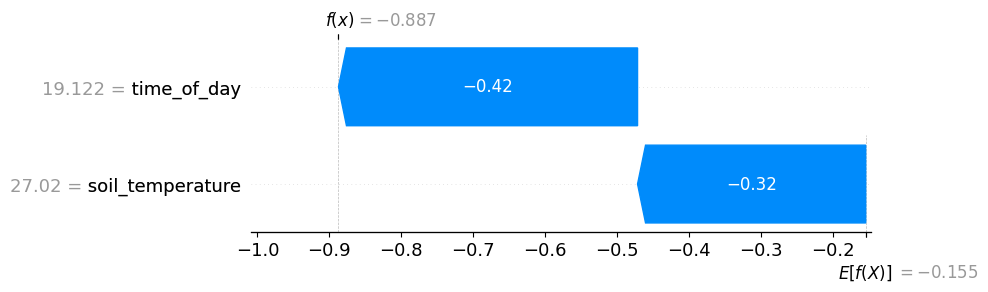

In [20]:
explainer = shap.Explainer(reg_two_vars, feature_names=["time_of_day", "soil_temperature"])
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

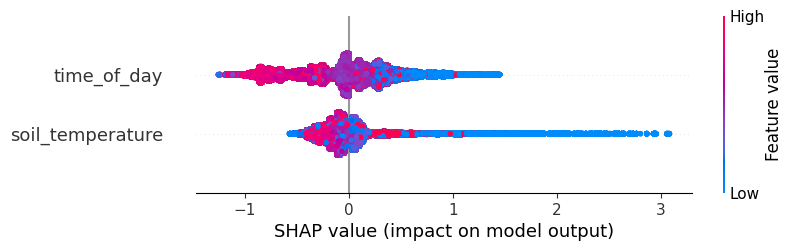

In [21]:
shap.plots.beeswarm(shap_values)